In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Apr  9 01:28:21 2020

@author: shashank
"""
from os import listdir, path, makedirs, environ
# To make tf stfu
environ["TF_CPP_MIN_LOG_LEVEL"]="2"


import librosa
import numpy as np
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Input, GRU
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
from sklearn.utils import shuffle
import json
from tensorflow.keras.utils import plot_model
#from utils import Config
from tensorflow.keras.regularizers import l1_l2
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint

In [13]:
error_files = [
    'mandarin_0070.wav',
    'english_0076.wav',
    'mandarin_0062.wav',
    'english_0085.wav',
    'english_0120.wav',
    'mandarin_0085.wav',
    'hindi_0028.wav',
    'mandarin_0049.wav',
    'english_0069.wav',
    'mandarin_0048.wav',
    'mandarin_0054.wav',
    'english_0097.wav',
    'english_0071.wav'
  ]

def getFeatures(pat):
    fets=[]
    cut = Config['cut']
    for f in tqdm(listdir(pat)[:Config['max_samples']:]):
        if f in error_files:
            y,sr=librosa.load(path.join(pat,f),sr=44100)
        else:
            y,sr=librosa.load(path.join(pat,f),sr=16000)
        #y_ = y[:(len(y)//(int(sr*0.025)))*(int(sr*0.025))].reshape(int(len(y)/int(sr*0.025)),(int(sr*0.025)))
        #y_2 = np.array([w for w in y_ if np.square(w).sum() > cut])
        #y = np.hstack(y_2)
        y = np.hstack([y[ind[0]:ind[1]] for ind in librosa.effects.split(y,cut)])
        mat = librosa.feature.mfcc(y=y,sr=sr,n_mfcc=64,n_fft=int(sr*0.025), hop_length=int(sr*0.010))
        fets.append(mat)
    m = np.hstack(fets)
    l = (len(m[0])//Config['S'])*Config['S']
    ma = m[:,:l]
    mb = ma.reshape(64,int(l/Config['S']),Config['S']).swapaxes(0,1).swapaxes(1,2)
    return mb


def getData(train=True):
    if train:
        m_f = getFeatures(path.join(Config['main_dir_train'],'train_mandarin'))
        h_f = getFeatures(path.join(Config['main_dir_train'],'train_hindi'))
        e_f = getFeatures(path.join(Config['main_dir_train'],'train_english'))
    else:
        m_f = getFeatures(path.join(Config['main_dir_test'],'test_mandarin'))
        h_f = getFeatures(path.join(Config['main_dir_test'],'test_hindi'))        
        e_f = getFeatures(path.join(Config['main_dir_test'],'test_english'))
#    e_t = 0*np.ones((e_f.shape[0],e_f.shape[1],1))
#    h_t = 1*np.ones((h_f.shape[0],h_f.shape[1],1))
#    m_t = 2*np.ones((m_f.shape[0],m_f.shape[1],1))
    e_t = np.array(e_f.shape[0]*[e_f.shape[1]*[[1,0,0]]])
    h_t = np.array(h_f.shape[0]*[h_f.shape[1]*[[0,1,0]]])
    m_t = np.array(m_f.shape[0]*[m_f.shape[1]*[[0,0,1]]])
    X = np.concatenate((e_f,m_f,h_f), axis = 0)
    Y = np.concatenate((e_t,m_t,h_t), axis = 0)
    # if train:
    #     np.save('/content/drive/My Drive/EE599/HW5/npys/X_train.npy', X)
    #     np.save('/content/drive/My Drive/EE599/HW5/npys/Y_train.npy', Y)
    # else:
    #     np.save('/content/drive/My Drive/EE599/HW5/npys/X_test.npy', X)
    #     np.save('/content/drive/My Drive/EE599/HW5/npys/Y_test.npy', Y)      
    if train:
        return train_test_split(X, Y, test_size=0.1)
    else:
        return shuffle(X,Y)


def plot(hist,loss):
    fig, axs = plt.subplots(2)
    fig.suptitle('Test accuracy: '+str(loss[1])+ '  Test loss: '+str(loss[0]))
    
        
    axs[0].plot(hist.history['accuracy'])
    axs[0].plot(hist.history['val_accuracy'])
    # axs[0].set_title('Test accuracy: '+str(loss[1]))
    axs[0].set_ylabel('Accuracy')
    # axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'valid'], loc='upper left')
    
    axs[1].plot(hist.history['loss'])
    axs[1].plot(hist.history['val_loss'])
    # axs[1].set_title('Test loss: '+str(loss[0]))
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'valid'], loc='upper right')
    return fig,axs

In [14]:
Config = {
    'S':200,
    'main_dir_train':'/home/shashank/Desktop/Coursework/Sem2/DeepLearning/Week5/train',
    'main_dir_test':'/home/shashank/Desktop/Coursework/Sem2/DeepLearning/Week5/test',
    'max_samples':30,
    'batch_size':32,
    'max_epochs':10,
    'name':'GRU3',
    'save_path':'saves',
    'valid_new_samples':True,
    'cut' : 10
    }

# Get data
X_train, X_valid, y_train, y_valid = getData(train=True)
X_test, y_test = getData(train=False)    
input_shape = (X_train.shape[1], X_train.shape[2])
# y_integers = np.argmax(np.reshape(y_train, (y_train.shape[0]*y_train.shape[1],3)), axis=1)
# class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
# d_class_weights = dict(enumerate(class_weights))

100%|██████████| 5/5 [00:01<00:00,  4.07it/s]


In [15]:
def getModel(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    #model.add(GRU(units=128, dropout = 0.5, return_sequences=True, stateful=False))
    model.add(GRU(units=64, dropout = 0.5, return_sequences=True, stateful=False))
    model.add(GRU(units=56, dropout = 0.5, return_sequences=True, stateful=False))
    model.add(GRU(units=48, dropout = 0.5, return_sequences=True, stateful=False))
    model.add(GRU(units=40, dropout = 0.5, return_sequences=True, stateful=False))
    model.add(GRU(units=32, dropout = 0.5, return_sequences=True, stateful=False))
    model.add(GRU(units=24, dropout = 0.5, return_sequences=True, stateful=False))
    model.add(GRU(units=16, dropout = 0.5, return_sequences=True, stateful=False))
    model.add(GRU(units=8, dropout = 0.5, return_sequences=True, stateful=False))
    model.add(Dense(units=y_train.shape[2], activation="softmax"
                    , kernel_regularizer=l1_l2(l1=0.0001, l2=0.01)
                    ))
    model.summary()
    return model

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_32 (GRU)                 (None, 200, 64)           24960     
_________________________________________________________________
gru_33 (GRU)                 (None, 200, 56)           20496     
_________________________________________________________________
gru_34 (GRU)                 (None, 200, 48)           15264     
_________________________________________________________________
gru_35 (GRU)                 (None, 200, 40)           10800     
_________________________________________________________________
gru_36 (GRU)                 (None, 200, 32)           7104      
_________________________________________________________________
gru_37 (GRU)                 (None, 200, 24)           4176      
_________________________________________________________________
gru_38 (GRU)                 (None, 200, 16)          

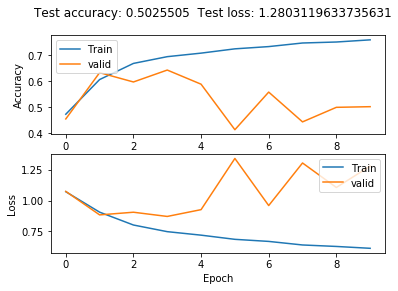

In [16]:
# Get model
model = getModel(input_shape)

mcp_save = ModelCheckpoint(Config['name']+'best.h5', save_best_only=True, monitor='val_accuracy', mode='max')

# Train and test model
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train, y_train,
          batch_size=Config['batch_size'],
          epochs=Config['max_epochs'],
          # validation_data=None,
          validation_data = [X_test,y_test],
          callbacks=[mcp_save]
          # class_weight = d_class_weights
          )
loss = model.evaluate(X_test,y_test)    
fig,axs = plot(hist,loss)

# Save results
makedirs(path.join(Config['save_path'],Config['name']))    
plot_model(model,path.join(Config['save_path'],Config['name'])+'/'+Config['name']+'_model.png', show_shapes=True)
with open(path.join(Config['save_path'],Config['name'])+'/'+Config['name']+'.txt', 'w') as file:
     file.write(json.dumps(Config))
model.save(path.join(Config['save_path'],Config['name'])+'/'+Config['name']+'.h5')
fig.savefig(path.join(Config['save_path'],Config['name'])+'/'+Config['name']+'_lc.png')

In [2]:
def getStreamingModel():
    model = Sequential()
    model.add(Input(batch_shape=(1,None,64)))
    model.add(GRU(units=64, dropout = 0.5, return_sequences=True, stateful=True))
    model.add(GRU(units=56, dropout = 0.5, return_sequences=True, stateful=True))
    model.add(GRU(units=48, dropout = 0.5, return_sequences=True, stateful=True))
    model.add(GRU(units=40, dropout = 0.5, return_sequences=True, stateful=True))
    model.add(GRU(units=32, dropout = 0.5, return_sequences=True, stateful=True))
    model.add(GRU(units=24, dropout = 0.5, return_sequences=True, stateful=True))
    model.add(GRU(units=16, dropout = 0.5, return_sequences=True, stateful=True))
    model.add(GRU(units=8, dropout = 0.5, return_sequences=False, stateful=True))
    model.add(Dense(units=3, activation="softmax"
                    , kernel_regularizer=l1_l2(l1=0.0001, l2=0.01)
                    ))
    model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    model.load_weights('/home/shashank/Desktop/Coursework/Sem2/DeepLearning/Week5/GRU3best.h5')

    return model

def streamThroughFile(fil,model):
    y,sr=librosa.load(fil,sr=16000)
    mat = librosa.feature.mfcc(y=y,sr=sr,n_mfcc=64,n_fft=int(sr*0.025), hop_length=int(sr*0.010))
    l = []
    for f in tqdm(mat.T):
        language_vec = model.predict(f.reshape(1,1,64))
        l.append(language_vec[0])
    model.reset_states()
    return l

In [ ]:
fil = '/home/shashank/Desktop/Coursework/Sem2/DeepLearning/Week5/stream_test/hindi_0033.wav'
model = getStreamingModel()
preds = streamThroughFile(fil,model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (1, None, 64)             24960     
_________________________________________________________________
gru_1 (GRU)                  (1, None, 56)             20496     
_________________________________________________________________
gru_2 (GRU)                  (1, None, 48)             15264     
_________________________________________________________________
gru_3 (GRU)                  (1, None, 40)             10800     
_________________________________________________________________
gru_4 (GRU)                  (1, None, 32)             7104      
_________________________________________________________________
gru_5 (GRU)                  (1, None, 24)             4176      
_________________________________________________________________
gru_6 (GRU)                  (1, None, 16)             2

 77%|███████▋  | 46335/60067 [15:16<04:51, 47.09it/s]